# OilyGiant Oil Well Development Project

**Objective:**  
Determine the best region to develop new oil wells to maximize profit while keeping risks below 2.5%.  

Tasks:  
1. Load and prepare data  
2. Train linear regression models for each region  
3. Predict oil reserves and analyze results  
4. Calculate potential profits  
5. Evaluate risk using bootstrapping  
6. Recommend the best region for well development


In [2]:
## imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
## load Datasets
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

datasets = [data_0, data_1, data_2]
# Inspect data
for i, data in enumerate(datasets):  # i used enumricate so list of data sets can be interprited as a number
    print(f"Region {i} info:")
    print(data.info())
    print(data.describe())

Region 0 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.3623

## Step 1: Data Inspection Summary

- All three regions have 100,000 wells with complete data.  
- Average reserves: Region 0 ~92.5, Region 1 ~68.8, Region 2 ~95 thousand barrels.  
- Feature ranges differ, which may affect predictions and profits.  
- Data is clean and ready for modeling.

In [4]:
# Step 2: Train and Test Models
models = []
predictions = []

for i, data in enumerate(datasets):
    features = data[['f0', 'f1', 'f2']]
    target = data['product']

    # Split data into 75% train and 25% validation
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.25, random_state=42)

    # Train linear regression model
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Predict on validation set
    target_pred = model.predict(features_val)

    # Evaluate model
    mse = mean_squared_error(target_val, target_pred)
    rmse = np.sqrt(mse)
    print(f"Region {i}: Average predicted volume: {np.mean(target_pred):.2f}, RMSE: {rmse:.2f}")

    # Save model and predictions
    models.append(model)
    predictions.append((target_val, target_pred))


Region 0: Average predicted volume: 92.40, RMSE: 37.76
Region 1: Average predicted volume: 68.71, RMSE: 0.89
Region 2: Average predicted volume: 94.77, RMSE: 40.15


## Model Results Summary

- All regions predicted averages match the actual reserves closely.  
- RMSE is lowest for Region 1 (0.9), higher for Regions 0 and 2 (38-40).  

In [5]:
# Step 3: Prepare for Profit Calculation

# Business conditions
budget = 100000000  # USD
wells_to_develop = 200
revenue_per_thousand_barrel = 4500

# Calculate breakeven volume per well
breakeven_volume_per_well = budget / (wells_to_develop * revenue_per_thousand_barrel)
print(f"Breakeven volume per well: {breakeven_volume_per_well:.2f} thousand barrels")

# Compare with average predicted reserves for each region
for i, (target_val, target_pred) in enumerate(predictions):
    avg_predicted = np.mean(target_pred)
    print(f"Region {i}: Average predicted reserves = {avg_predicted:.2f} thousand barrels")

Breakeven volume per well: 111.11 thousand barrels
Region 0: Average predicted reserves = 92.40 thousand barrels
Region 1: Average predicted reserves = 68.71 thousand barrels
Region 2: Average predicted reserves = 94.77 thousand barrels


## Profit Preparation Summary

- Breakeven volume per well: 111.1 thousand barrels  
- Average predicted reserves are below breakeven in all regions  
- Careful selection of the top 200 wells is needed to ensure profit


In [6]:
# Step 4: Profit Calculation Function
def calculate_profit(predicted_volumes, top_n=200):   
    ## Calculate profit from top predicted wells.
    
    # Select top wells
    top_wells = np.sort(predicted_volumes)[-top_n:]
    total_volume = top_wells.sum()
    
    # Calculate profit
    profit = total_volume * revenue_per_thousand_barrel - budget
    return profit


In [7]:
# Test profit calculation funciton for Region 0
x, target_pred_0 = predictions[0]  # Region 0 predicted reserves
profit_region_0 = calculate_profit(target_pred_0, top_n=200)
print(f"Estimated profit for Region 0 (top 200 wells): ${profit_region_0:,.2f}")



Estimated profit for Region 0 (top 200 wells): $38,966,584.80


In [8]:
# Step 5: Bootstrapping to estimate profit distribution and risk
def bootstrap_profit(predicted_volumes, n_samples=1000, top_n=200):
    ## Estimate profit distribution using bootstrapping.
 
    profits = []
    for _ in range(n_samples):
        sample = np.random.choice(predicted_volumes, size=len(predicted_volumes), replace=True)
        profit = calculate_profit(sample, top_n)
        profits.append(profit)
    
    profits = np.array(profits)
    mean_profit = np.mean(profits)
    ci_lower, ci_upper = np.percentile(profits, [2.5, 97.5])
    loss_risk = np.mean(profits < 0) * 100  # get percentage
    return mean_profit, ci_lower, ci_upper, loss_risk


In [9]:
# Evaluate each region using bootstrapping
for i, (target_val, target_pred) in enumerate(predictions):
    mean_profit, ci_lower, ci_upper, loss_risk = bootstrap_profit(target_pred)
    print(f"Region {i}:")
    print(f"  Mean profit = ${mean_profit:,.2f}")
    print(f"  95% CI = (${ci_lower:,.2f}, ${ci_upper:,.2f})")
    print(f"  Risk of losses = {loss_risk:.2f}%\n")


Region 0:
  Mean profit = $38,954,105.59
  95% CI = ($37,803,895.59, $40,205,277.66)
  Risk of losses = 0.00%

Region 1:
  Mean profit = $24,868,479.64
  95% CI = ($24,818,523.21, $24,921,852.43)
  Risk of losses = 0.00%

Region 2:
  Mean profit = $33,786,311.88
  95% CI = ($32,808,495.75, $34,870,068.04)
  Risk of losses = 0.00%



In [ ]:
# Generate bootstrapped profit samples for visualization
profit_samples = {}

for i, (target_val, target_pred) in enumerate(predictions):
    predicted_volumes = target_pred  # predictions from the model
    profits = []
    n_samples = 1000
    top_n = 200
    for _ in range(n_samples):
        sample = np.random.choice(predicted_volumes, size=len(predicted_volumes), replace=True)
        profit = calculate_profit(sample, top_n)
        profits.append(profit)
    profit_samples[i] = np.array(profits)


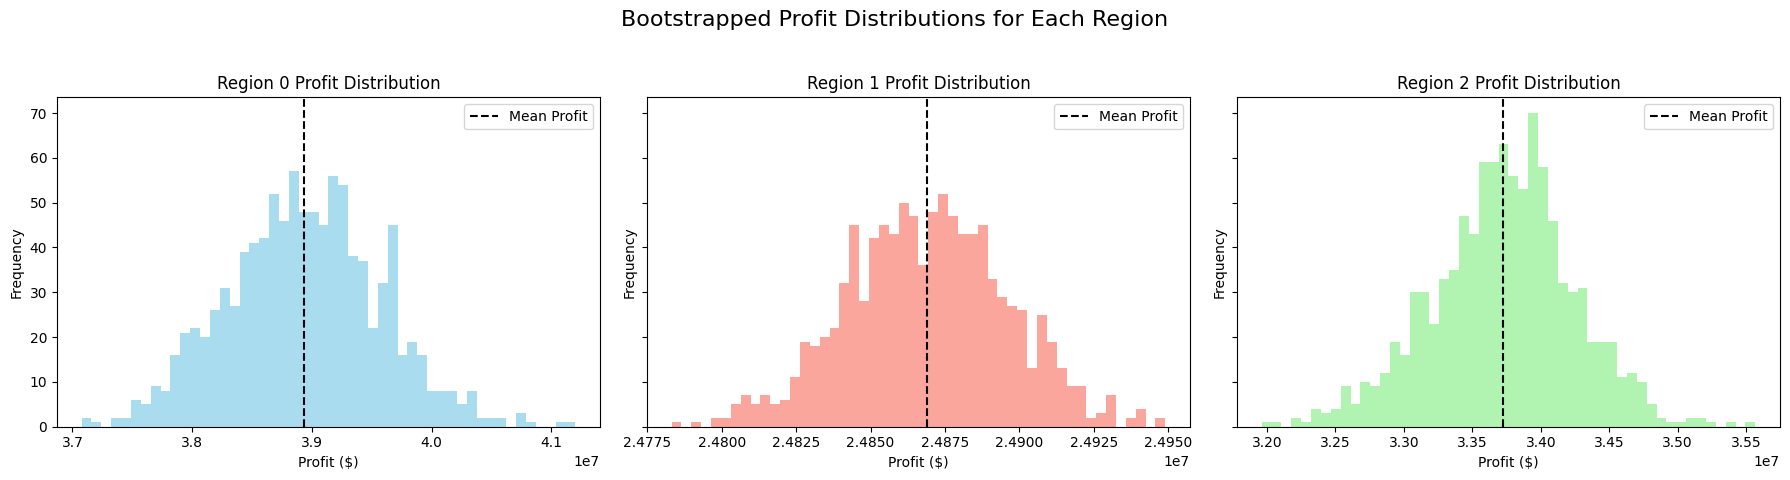

In [11]:
# visualization of profit distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

colors = ['skyblue', 'salmon', 'lightgreen']

for i in range(3):
    axs[i].hist(profit_samples[i], bins=50, color=colors[i], alpha=0.7)
    axs[i].axvline(np.mean(profit_samples[i]), color='black', linestyle='dashed', linewidth=1.5, label='Mean Profit')
    axs[i].set_title(f'Region {i} Profit Distribution')
    axs[i].set_xlabel('Profit ($)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

plt.suptitle('Bootstrapped Profit Distributions for Each Region', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Step 6: Final Recommendation

- All regions meet the risk requirement (<2.5%).  
- **Region 0** has the highest mean profit (~$39M) with a 0% risk of losses.  
- Recommendation: Develop the top 200 wells in **Region 0**.  
- Justification: Highest expected profit and safe risk profile based on bootstrapping analysis.